# Regresión Lineal II

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.gaussian_process.kernels import RBF
import ipywidgets as ipy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


En la celda siguiente de definiran las funciónes para la generación de los sistemas con los que se van a trabajar.

In [23]:
def sistema1(x,sigma = .1):
    w0 = -0.3
    w1 = 0.5
    y = w0 + w1*x
    e = sigma*np.random.randn(y.shape[0],y.shape[1])
    t = y + e
    return t,y

def sistema2(x,sigma = .02):
    y = np.sin(2*np.pi*x)
    e = sigma*np.random.randn(y.shape[0],y.shape[1])
    t = y + e
    return t,y


def plot_posterioriRecta(xx,tt,m,S,xlim = [-1,1],ylim = [-1,1],w = [-0.3,0.5],nF = 5,title = ''):
    #%% Para la gráfica del Piori
    x = np.linspace(xlim[0],xlim[1],50)
    y = np.linspace(ylim[0],ylim[1],50)
    w_x,w_y = np.meshgrid(x,y)
    wx_v = w_x.reshape((w_x.size,1))
    wy_v = w_y.reshape((w_y.size,1))
    pdf_mnd = multivariate_normal(m.reshape((m.size,)),S)
    Probability = pdf_mnd.pdf(np.concatenate((wx_v,wy_v),axis = 1)).reshape(w_x.shape)
    #%% Para generar los modelos apartir de la distribución
    W = np.random.multivariate_normal(m.reshape((m.size,)),S,nF) # apartir del vector de media y la matriz de covarianza genera nF valores aleatorios para w0 y w1
    yy = []
    X = []

    plt.figure()

    plt.subplot(1,2,2)
    for i in range(nF):
        yy = W[i,0] + W[i,1]*x
        plt.plot(x,yy,color = 'r')
    plt.plot(xx,tt,'ob')
    plt.xlabel('x')
    #%% Graficas
    plt.subplot(1,2,1)
    #plt.imshow(Probability)
    plt.contourf(w_x,w_y,Probability)
    plt.plot(w[0],w[1],'+k')
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.axis('square')
    plt.suptitle(title)
    plt.show()

def plot_posteriori(x,Phi,xx,tt,m,S,plot_std = False,t_mean =None,t_var=None,xlim = [-1,1],ylim = [-1,1],nF = 5,title = '',betaInv = 0.1):
    #%% Para la gráfica del Piori
    #%% Para generar los modelos apartir de la distribución
    W = np.random.multivariate_normal(m.reshape((m.size,)),S,nF) # apartir del vector de media y la matriz de covarianza genera nF valores aleatorios para w0 y w1
    yy = []
    X = []
    plt.figure()
    for i in range(nF):
        yy = (Phi@W[i,:].T).reshape(-1,1)
        plt.plot(x,yy,linewidth = 2,color = 'r')
    plt.plot(xx,tt,'ob',markersize = 5,label = 'instances')
    plt.xlabel('x')
    plt.xlabel('t')

    if not(t_mean is None):
        plt.plot(x,t_mean,color='green',linewidth=2,label = 't_pred')
        t_mean = t_mean.reshape((t_mean.size,))
        t_var = t_var.reshape((t_var.size,))
        plt.fill_between(x.reshape((x.size,)),t_mean-t_var,t_mean+t_var,alpha=0.5,color = 'grey',label = 't_var')
    if plot_std:
        t_mean = Phi@m
        t_var = np.diag(betaInv + Phi@S@Phi.T)
        t_mean = t_mean.reshape((t_mean.size,))
        t_var = t_var.reshape((t_var.size,))
        plt.fill_between(x.reshape((x.size,)),t_mean-t_var,t_mean+t_var,alpha=0.5,color = 'green',label = 'variance')
    plt.suptitle(title)
    plt.legend()
    plt.show()

def plot_gd(X_train,t_train,y_train,X_test,t_test,y_test,w,log):

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.scatter(X_train, t_train,  color='blue',label='Training samples')
  plt.plot(X_test, t_test,  color='green',label='Ideal (test) signal')
  plt.plot(X_test, y_test,  color='red',label='Predicted signal')
  plt.xlabel('Input variable')
  plt.ylabel('Output variable')
  plt.title('Training MSE {}'.format(log[-1]))
  plt.ylim([-3,3])
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(log)
  plt.xlabel('Epochs')
  plt.ylabel('Cost function')
  plt.show()

def plot_reg(X_train,t_train,y_train,X_test,t_test,y_test,mu,w):

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.scatter(X_train, t_train,  color='blue',label='Training samples')
  plt.plot(X_test, t_test,  color='green',label='Ideal (test) signal')
  plt.plot(X_test, y_test,  color='red',label='Predicted signal')
  plt.xlabel('Input variable')
  plt.ylabel('Output variable')
  plt.ylim([-3,3])
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.stem(mu.reshape(-1,),w.reshape(-1,))
  plt.xlabel('Centroid')
  plt.ylabel('Weight')
  plt.show()

def plot_bayes(X_train,t_train,y_train,X_test,t_test,y_bayes,std_bayes):

  plt.scatter(X_train, t_train,  color='blue',label='Training samples')
  plt.plot(X_test, t_test,  color='green',label='Clean signal')
  plt.plot(X_test.reshape(-1,), y_bayes, color='blue',label='Bayesian regression')
  plt.fill_between(X_test.reshape(-1,), y_bayes.ravel()+std_bayes.ravel(), y_bayes.ravel()-std_bayes.ravel(), color='blue', alpha=0.2,label='Bayesian regression')
  plt.xlabel('Input variable')
  plt.ylabel('Output variable')
  plt.ylim([-3,3])
  plt.grid()
  plt.legend()
  plt.show()

def plot_bayes_log(log):
  plt.figure(figsize=[15,5])
  plt.subplot(1,3,1)
  plt.plot(log['alpha'])
  plt.xlabel('Epochs')
  plt.ylabel('alpha')
  plt.subplot(1,3,2)
  plt.plot(log['beta'])
  plt.xlabel('Epochs')
  plt.ylabel('beta')
  plt.subplot(1,3,3)
  plt.plot(log['loss'])
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.show()

El siguiente bloque define un arreglo uniformemente distribuido de valores (x) y calcula la salida del sistema uno (t) para cada valor. Además, se escogen de forma aleatoria $70$ muestras para el entrenamiento.

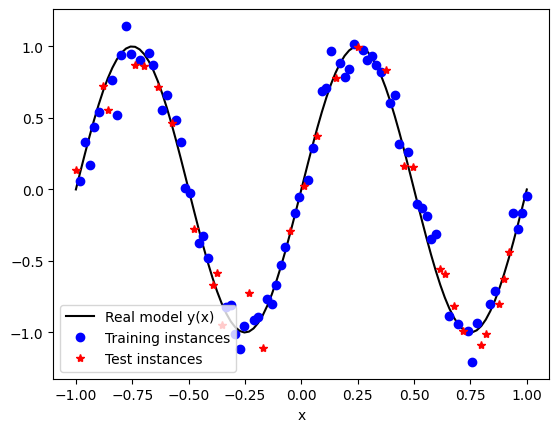

In [4]:
N = 100 # número total de muestras
x = np.linspace(-1,1,N).reshape(-1,1)
betaInv = 0.1
beta = float(1/betaInv)
t,y_real = sistema2(x,sigma=betaInv)
N_train = 70 # Número de muestras para el entrenamiento

ind_Train = np.random.permutation(N)[:N_train] # index de las muestras escogidas para entrenamiento
X_train = x[ind_Train,:] # muestras de entrada para el entrenamiento
y_train = t[ind_Train,:] # muestras de entrada para el entrenamiento

ind_Test = [i for i in range(len(x)) if i not in ind_Train] #indices en x que no son para train
X_test = x[ind_Test,:] # muestras de entrada para el test
y_test = t[ind_Test,:] # muestras de entrada para el test


plt.figure()
plt.plot(x,y_real,'k',label = 'Real model y(x)')
plt.plot(X_train,y_train,'ob',label = 'Training instances')
plt.plot(X_test,y_test,'*r',label = 'Test instances')
plt.xlabel('x')
plt.legend()
plt.show()

## Regularización

### data  train/test

In [5]:
poly = PolynomialFeatures(degree=2)
Phi_train = poly.fit_transform(X_train)
Phi_test = poly.fit_transform(X_test)

### Regresor Ridge manual

En el siguiente bloque se crea el regresor lineal con regularización norma-2.

* En la función `ridge_fit` tenemos que `w` esta dada por la solución de norma-2: $$w=(\Phi^\top\Phi+\alpha I_M)^{-1}\Phi^\top t$$

* La función `linear_predict` como vimos anteriormente: $y=\Phi w$

* Identifique el efecto de $\alpha$ en la regresión y escoja el que crea mejor.



In [6]:
def ridge_fit(Phi,t,alpha):
  #w = np.random.rand(mu.shape[0],1)
  w = np.linalg.inv( ( Phi.T @ Phi + alpha * np.eye( Phi.shape[1] ) ) ) @ (Phi.T@t)

  return w

def linear_predict(Phi,w):
  #y = np.random.rand(Phi.shape[0],1)
  y = Phi@w
  return y


def update_ridge(power):
  alpha = 10**power
  w = ridge_fit(Phi_train,y_train,alpha)
  y = linear_predict(Phi_test,w)

  # Un arreglo de centroides mu espaciados linealmente entre 0 y 1
  mu = np.random.rand(len(w),1)
  plot_reg(X_train,y_train,y_real,X_test,y_test,y,mu,w)

display(ipy.interactive(                                                        #Se crea el tablero
    update_ridge,
    power=ipy.FloatSlider(value=-15, min=-15, max=1, step=0.1,
                    description='power:',
                    continuous_update=True,
                    style=dict(description_width='initial')),
))

interactive(children=(FloatSlider(value=-15.0, description='power:', max=1.0, min=-15.0, style=SliderStyle(des…

### Ridge Sklearn

In [7]:
from sklearn.linear_model import Ridge

def update_ridge_sk(power):
  alpha = 10**power
  ####Ponga su código acá#######

  clf = Ridge(alpha)
  clf.fit(Phi_train, y_train)

  y_ridge = clf.predict(Phi_test)
  w_ridge = clf.coef_
  ##############################
  # Un arreglo de centroides mu espaciados linealmente entre 0 y 1
  plot_reg(X_train,y_train,y_real,X_test,y_test,y_ridge,np.random.rand(max(w_ridge.shape)),w_ridge)


display(ipy.interactive(                                                        #Se crea el tablero
    update_ridge_sk,
    power=ipy.FloatSlider(value=-15, min=-15, max=1, step=0.1,
                    description='power:',
                    continuous_update=True,
                    style=dict(description_width='initial')),
))

interactive(children=(FloatSlider(value=-15.0, description='power:', max=1.0, min=-15.0, style=SliderStyle(des…

### Lasso sklearn

In [8]:
from sklearn.linear_model import Lasso

def update_lasso_sk(power):
  alpha = 10**power
  ####Ponga su código acá#######

  lasso = Lasso(alpha)
  lasso.fit(Phi_train, y_train)

  y_lasso = lasso.predict(Phi_test)
  w_lasso = lasso.coef_

  #y_lasso = np.random.rand(X_test.shape[0],1)
  #w_lasso = np.random.rand(mu.shape[0],1)

  ##############################


  plot_reg(X_train,y_train,y_real,X_test,y_test,y_lasso,np.random.rand(max(w_lasso.shape)),w_lasso)


display(ipy.interactive(                                                        #Se crea el tablero
    update_lasso_sk,
    power=ipy.FloatSlider(value=-15, min=-15, max=1, step=0.1,
                    description='power:',
                    continuous_update=True,
                    style=dict(description_width='initial')),
))

interactive(children=(FloatSlider(value=-15.0, description='power:', max=1.0, min=-15.0, style=SliderStyle(des…

## Bayesian Linear Regression

Partiendo de las muestras generadas a través del sistema1, modelo lineal con ruido $\epsilon \sim \mathcal{N}(\mathbf{0},\beta^{-1}=0.01)$, y suponiendo que $\mathbf{w}\sim\mathcal{N}(\mathbf{m}_0=\mathbf{0},\mathbf{S}_0=\alpha^{-1}\mathbf{I}=2\mathbf{I})$.

Calculamos el *MAP (Maximum A Posteriori)* a partir de una (N) muestras.

 Y generamos modelos a partir de las distribuciones a Porteriori.
 Para esto, desde el modelo de priori calculamos el Posteriori($\mathbf{m}_n$,$\mathbf{S}_n$), primero con una muestra, y graficalo por medio de la función **plot_posterioriRecta(XX,tt,mn,Sn)** (XX y tt son las muestras y sus salidas con las que calcularon $\mathbf{m}_n$ y $\mathbf{S}_n$).

 ¿Qué sucede a medida que va aumentando el número de muestras para el calculo del posteriori? ¿Tiene esto sentido?.

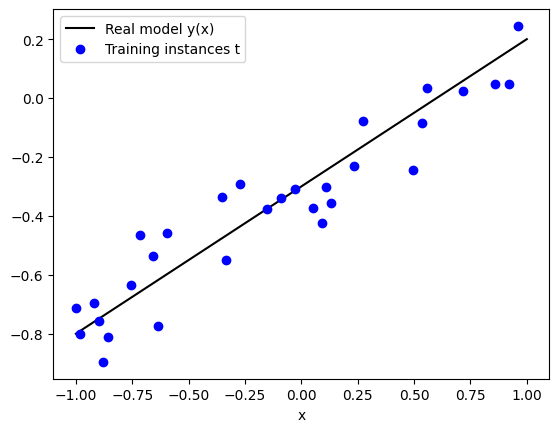

In [31]:
N = 100 # número total de muestras
x = np.linspace(-1,1,N).reshape(-1,1)
betaInv = 0.1
beta = float(1/betaInv)
t,y_real = sistema1(x,sigma=betaInv)
N_train = 30 # Número de muestras para el entrenamiento
ind_Train = np.random.permutation(N)[:N_train] # index de las muestras escogidas para entrenamiento
xTrain = x[ind_Train,:] # muestras de entrada para el entrenamiento
tTrain = t[ind_Train,:] # muestras de entrada para el entrenamiento

plt.figure()
plt.plot(x,y_real,'k',label = 'Real model y(x)')
plt.plot(xTrain,tTrain,'ob',label = 'Training instances t')
plt.xlabel('x')
plt.legend()
plt.show()

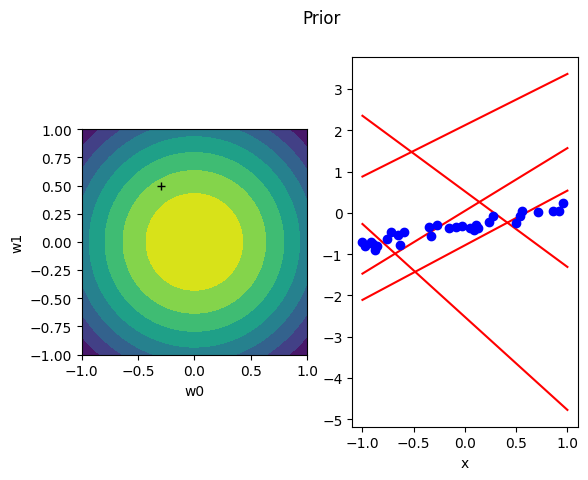

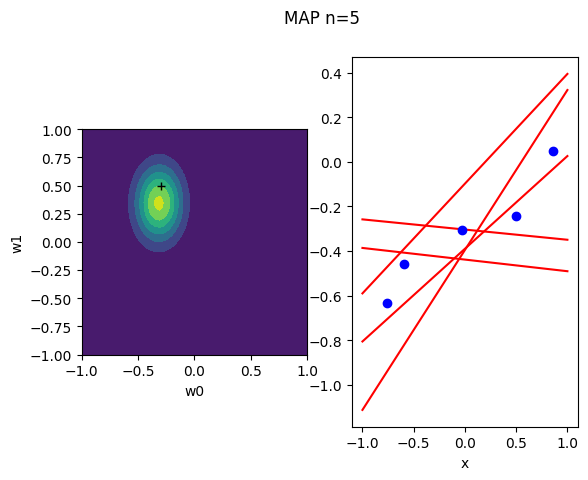

In [32]:
M = 2 # Número de pesos
alphaInv = 2
alpha  = float(1/alphaInv)
#%% modelo del Priori
m0 = np.zeros((M,)) # vector de ceros
S0 = alphaInv*np.eye(M)
#%% calculo de la probabilidad para parejas de (w0 y w1) y modelos lineales que pueden salir con este
plot_posterioriRecta(xTrain,tTrain,m0,S0,title = 'Prior')

#%%
# Se scojen las muestras con las que van a usar para implementar MAP
# Calcular mn y Sn con las muestras escojidas

N=5
x_train = xTrain[:N]
t_train = tTrain[:N]


Phi = np.concatenate([np.ones(x_train.shape),x_train],axis=1)
t = t_train
SN =  np.linalg.inv(  alpha * np.eye( Phi.shape[1] ) + beta * Phi.T @ Phi)
mn = beta * SN @ Phi.T @ t

plot_posterioriRecta(x_train,t_train,mn,SN,title = 'MAP n='+str(N))



El siguiente bloque define un arreglo uniformemente distribuido de valores (x) y calcula la salida del sistema dos (t) para cada valor. Además, se escogen de forma aleatoria $30$ muestras para el entrenamiento.

(100, 1) (100, 1)


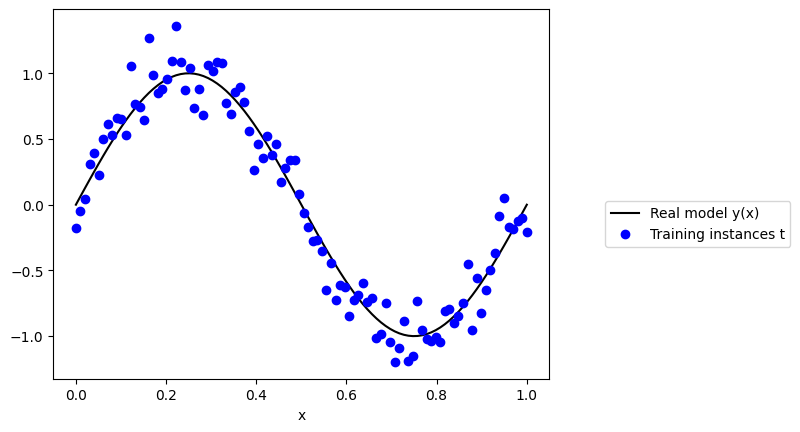

In [41]:
N = 100 # número total de muestras
x = np.linspace(0,1,N).reshape(-1,1)
betaInv = 0.15
beta = float(1/betaInv)
t,y_real = sistema2(x,sigma=betaInv)
N_train = 100 # Número de muestras para el entrenamiento
ind_Train = np.random.permutation(N)[:N_train] # index de las muestras escogidas para entrenamiento
xTrain = x[ind_Train,:] # muestras de entrada para el entrenamiento
tTrain = t[ind_Train,:] # muestras de entrada para el entrenamiento
print(xTrain.shape, tTrain.shape)
plt.figure()
plt.plot(x,y_real,'k',label = 'Real model y(x)')
plt.plot(xTrain,tTrain,'ob',label = 'Training instances t')
plt.xlabel('x')
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

Cambiemos ahora las bases linear por una rbf

In [42]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel


SN (2, 2) phi (2, 2) t_train (2, 1) x_train (2, 1)
x_train (2, 1) phi (2, 2) xTrain (100, 1) tTrain (100, 1) mn (2, 1) SN (2, 2)


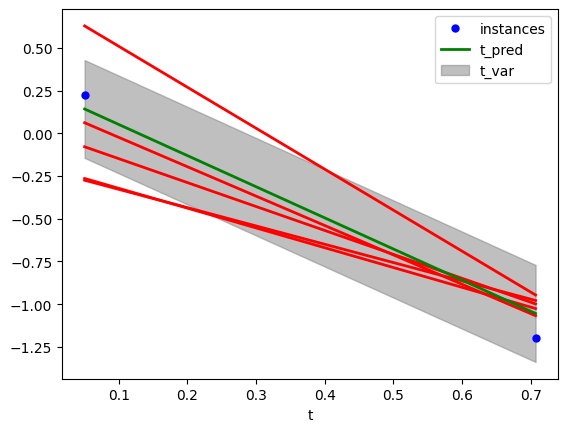

In [46]:
M = 100 # Número de pesos
x = np.linspace(0,1,M).reshape(-1,1)
alphaInv = 2
alpha  = float(1/alphaInv)
#%% modelo del Priorian
m0 = np.zeros((M,)) # vector de ceros
S0 = alphaInv*np.eye(M)

lengthscale = 0.1
#%% Your code
# escojan las muestras con las que van a usar para implementar MAP
# Calcular mn y Sn con las muestras escojidas}
N=2
x_train = xTrain[:N]
t_train = tTrain[:N]

mu = np.linspace(0, 1, N).reshape(-1, 1)
sigma = 0.5
gamma = 1/(2*sigma**2)
phi = rbf_kernel(x_train, mu, gamma)

#phi=rbf(x_train,mu)
#Phi = np.concatenate([np.ones(x_train.shape),x_train],axis=1)

SN =  np.linalg.inv(  alpha * np.eye(phi.shape[1]) + (beta * (phi.T @ phi)) )
print("SN",SN.shape,"phi",phi.shape,"t_train",t_train.shape,"x_train",x_train.shape)
mn = beta * SN @ phi.T @ t_train

t_mean = phi @ mn
t_var = 1/beta + np.diag( phi @ SN @ phi.T  )

print("x_train",x_train.shape,"phi",phi.shape,"xTrain",xTrain.shape,"tTrain",tTrain.shape,"mn",mn.shape,"SN",SN.shape)
# usar la función plot_posteriori(x,Phi_plot,xx,tt,mn,Sn,plot_std=True,xlim=[x.min(),x.max()],title = 'titulo opcional') (XX y tt son las muestras y sus salidas con las que calcularon 𝐦𝑛 y 𝐒𝑛)
#plot_posteriori(x_train,phi,x_train,t_train,mn,SN)
plot_posteriori(x_train,phi,x_train,t_train,mn,SN,t_mean=t_mean,t_var=t_var)


Ahora cambiemos los valores de $\beta$ y $\alpha$

¿Afecta los parámetros $\beta$ y $\sigma$ la predicción? Si la afecta ¿Cómo?

[1.0, 0.5, 0.3333333333333333, 0.25] [1000.0, 100.0, 10.0, 1]
Beta 1000.0 alpha 1.0


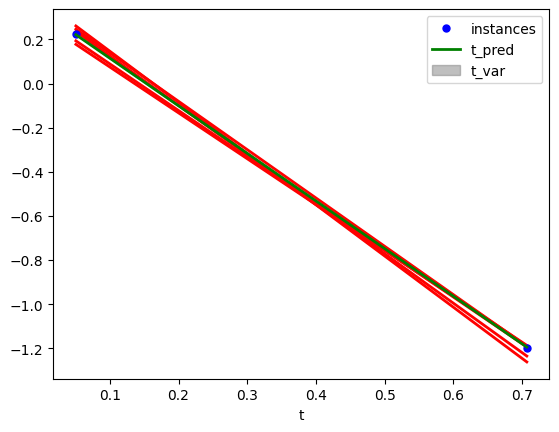

Beta 1000.0 alpha 0.5


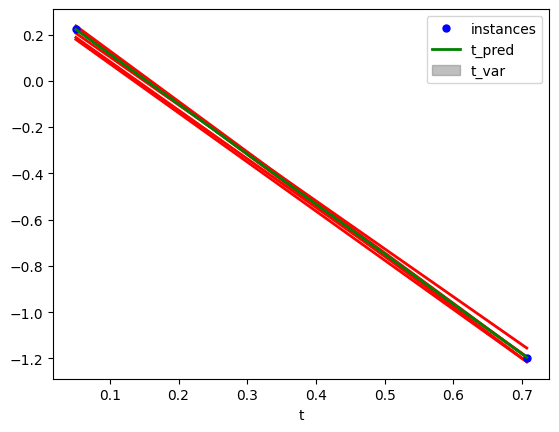

Beta 1000.0 alpha 0.3333333333333333


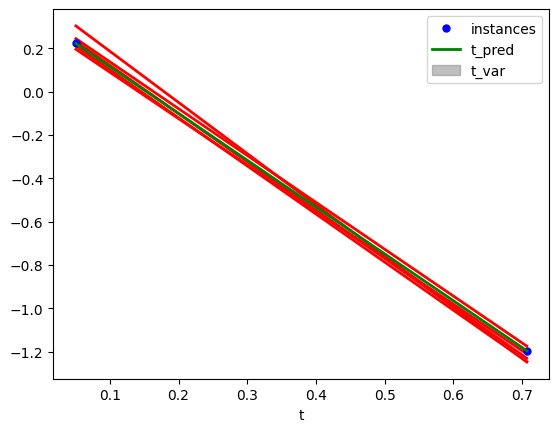

Beta 1000.0 alpha 0.25


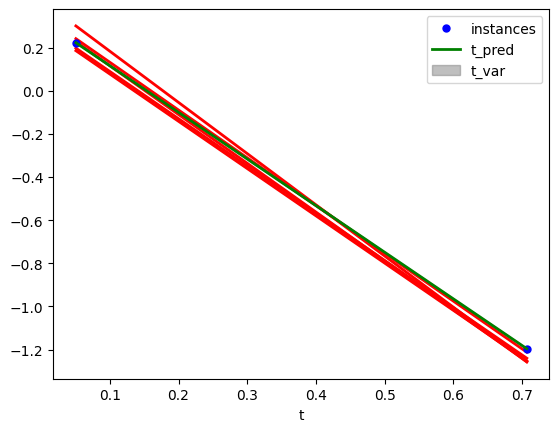

Beta 100.0 alpha 1.0


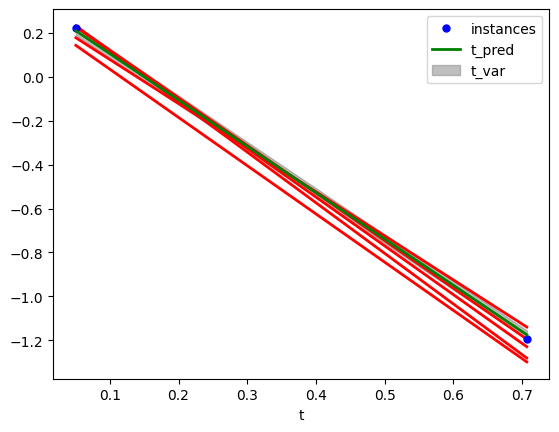

Beta 100.0 alpha 0.5


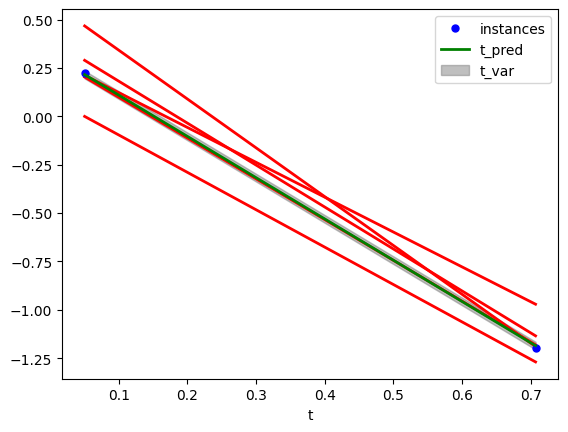

Beta 100.0 alpha 0.3333333333333333


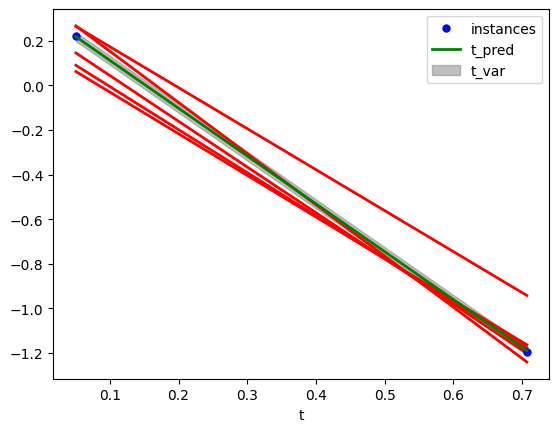

Beta 100.0 alpha 0.25


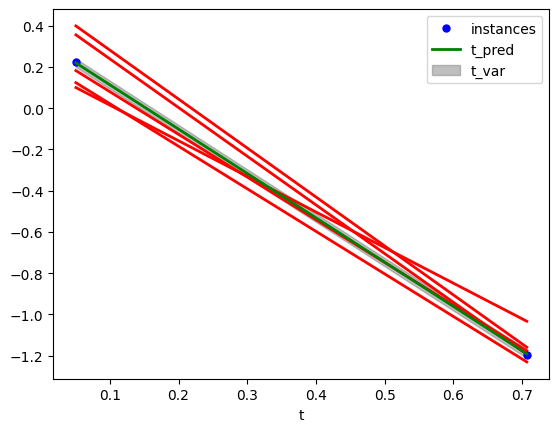

Beta 10.0 alpha 1.0


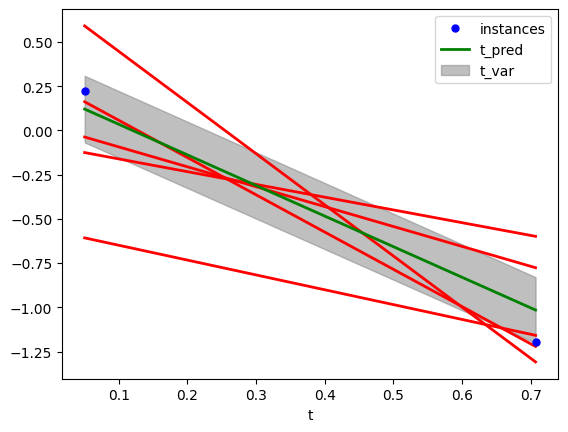

Beta 10.0 alpha 0.5


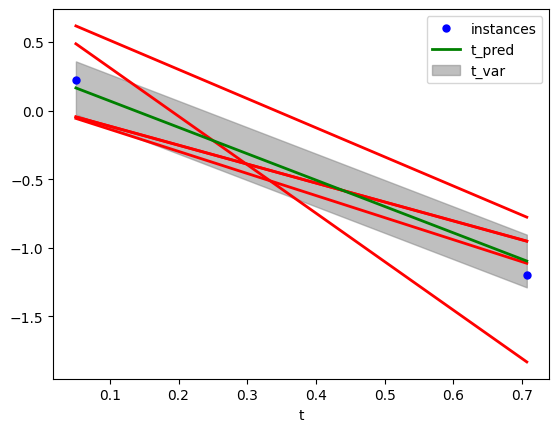

Beta 10.0 alpha 0.3333333333333333


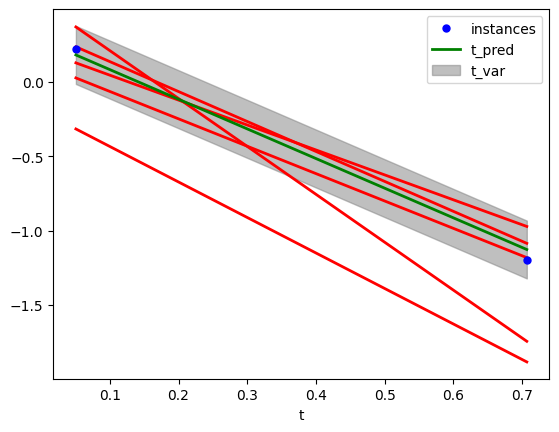

Beta 10.0 alpha 0.25


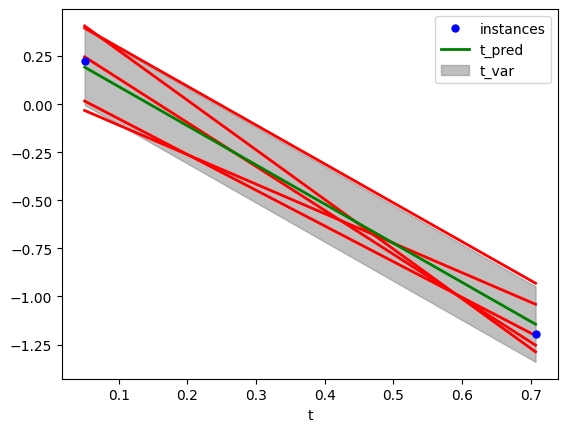

Beta 1 alpha 1.0


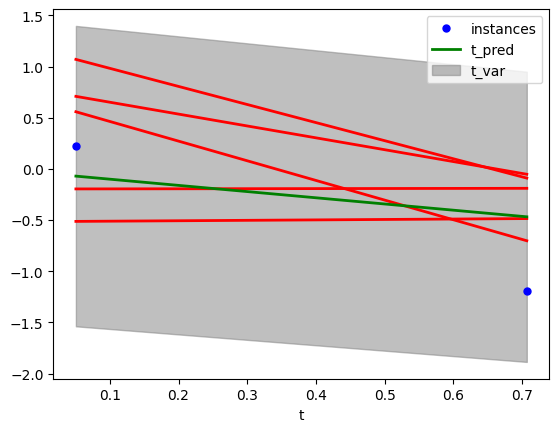

Beta 1 alpha 0.5


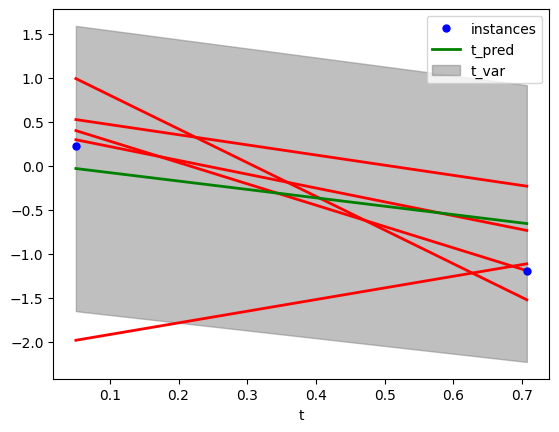

Beta 1 alpha 0.3333333333333333


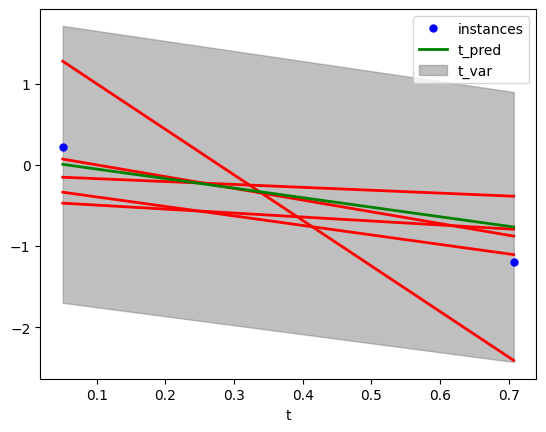

Beta 1 alpha 0.25


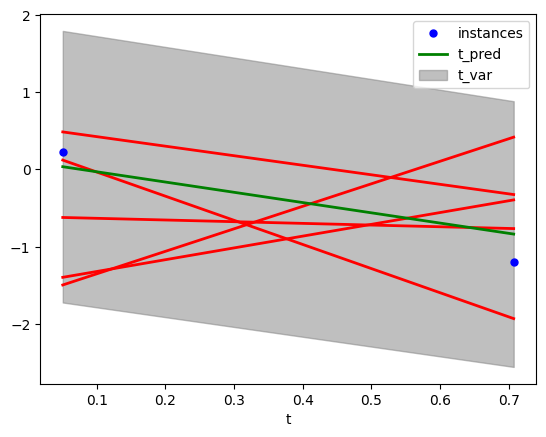

In [48]:
M = 100 # Número de pesos
alphaInv = [1,2,3,4]
alpha  = [float(1/alphaInv[0]),float(1/alphaInv[1]),float(1/alphaInv[2]),float(1/alphaInv[3])]
betaInv = [0.001,0.01,0.1,1]
beta = [1/0.001,1/0.01,1/0.1,1]
#%% modelo del Priori
m0 = np.zeros((M,)) # vector de ceros
#S0 = alphaInv*np.eye(M)

lengthscale = 0.1

print(alpha,beta)
N=2
x_train = xTrain[:N]
t_train = tTrain[:N]

mu = np.linspace(0, 1, N).reshape(-1, 1)
sigma = 0.5
gamma = 1/(2*sigma**2)
phi = rbf_kernel(x_train, mu, gamma)

#phi=rbf(x_train,mu)
#Phi = np.concatenate([np.ones(x_train.shape),x_train],axis=1)
for i in beta:
  for j in alpha:
    print("Beta",i, "alpha",j)
    SN =  np.linalg.inv(  j * np.eye(phi.shape[1]) + (i * (phi.T @ phi)) )
    mn = i * SN @ phi.T @ t_train
    t_mean = phi @ mn
    t_var = 1/i + np.diag( phi @ SN @ phi.T  )

    plot_posteriori(x_train,phi,x_train,t_train,mn,SN,t_mean=t_mean,t_var=t_var)

Ahora, Usando los mismo datos de entrenamiento del sistema2 (periodica)calculamos el Maximum A Posteriori(MAP) y a partir de esta calcula la distribución predictiva sobre *x* (variable) suponiendo que se desconoce los valores de $\beta$ y de $\alpha$.
Donde la media de esta última esta *t_mean_MAP* y la diagonal de la matiz de covarianza en *y_var_MAP*.

Ahora, compare este con el resultado obtenido realizando la predicción sobre *x* con la herramienta *sklearn.linear_model.BayesianRidge*, y guarde la predicción en *t_mean_sk* y su varianza en *t_var_sk*. Use en ambos casos funciones bases radiales (RBF).

¿Existe alguna diferencia en la predicción del MAP y la predcción por BayesianRidge? ¿sklearn.linear_model.BayesianRidge supone conocidos el $\alpha$ y el $\beta$? ¿Cómo estima estos parámetros?

(100, 1) (100, 1)


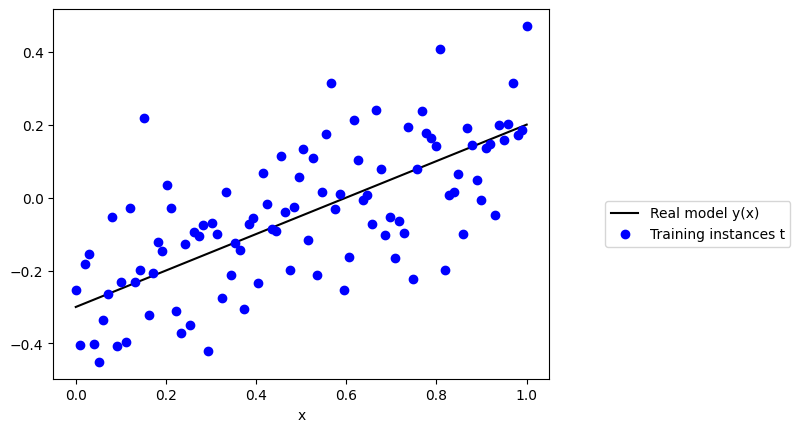

In [51]:
N = 100 # número total de muestras
x = np.linspace(0,1,N).reshape(-1,1)
betaInv = 0.15
beta = float(1/betaInv)
t,y_real = sistema1(x,sigma=betaInv)
N_train = 100 # Número de muestras para el entrenamiento
ind_Train = np.random.permutation(N)[:N_train] # index de las muestras escogidas para entrenamiento
xTrain = x[ind_Train,:] # muestras de entrada para el entrenamiento
tTrain = t[ind_Train,:] # muestras de entrada para el entrenamiento
print(xTrain.shape, tTrain.shape)
plt.figure()
plt.plot(x,y_real,'k',label = 'Real model y(x)')
plt.plot(xTrain,tTrain,'ob',label = 'Training instances t')
plt.xlabel('x')
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

t_mean_map  (100, 1) t_var_MAP  (100,) t_mean_sk  (100,) t_var_sk  ()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


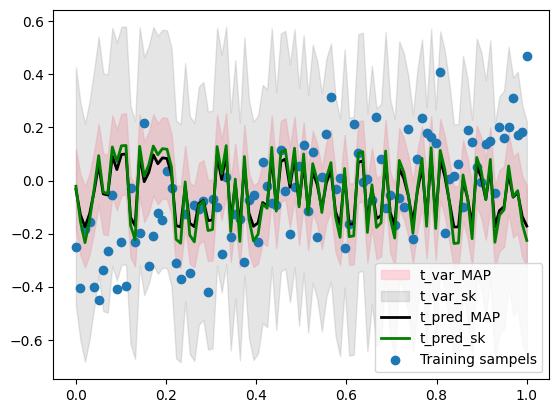

In [53]:
from sklearn import linear_model
M = 3 # número de funciones base
# Modelo Priori de los Ws
betaInv = 0.15
beta = float(1/betaInv)
alphaInv = 0.001 # 2
alpha = float(1/alphaInv)
m0 = np.zeros((M,)) # vector de ceros
S0 = alphaInv*np.eye(M)

x_train = xTrain
t_train = tTrain

## Base radial
mu = np.linspace(0, 1, N).reshape(-1, 1)
sigma = 0.5
gamma = 1/(2*sigma**2)
Phi = rbf_kernel(x_train, mu, gamma)


SN =  np.linalg.inv(  alpha * np.eye( Phi.shape[1] ) + beta * Phi.T @ Phi)
mn = beta * SN @ Phi.T @ t_train
t_mean_MAP = Phi @ mn
t_var_MAP = 1/beta + np.diag( Phi @ SN @ Phi.T  )
t_mean_MAP.reshape(-1)
## Base radial

clf = linear_model.BayesianRidge()
clf.fit(Phi, t_train)
t_mean_sk = clf.predict(Phi)
t_var_sk = clf.score(Phi, t_train)
#print(t_var_sk.shape)
print("t_mean_map ",t_mean_MAP.shape,"t_var_MAP ",t_var_MAP.shape,"t_mean_sk ",t_mean_sk.shape,"t_var_sk ",t_var_sk.shape)
#%%
plt.fill_between(x.reshape((x.size,)),t_mean_MAP.reshape(-1)-t_var_MAP,t_mean_MAP.reshape(-1)+t_var_MAP,color = 'pink',alpha = 0.6,label = 't_var_MAP')
plt.fill_between(x.reshape((x.size,)),t_mean_sk-t_var_sk,t_mean_sk+t_var_sk,color = 'gray',alpha = 0.2,label = 't_var_sk')
plt.plot(x,t_mean_MAP,linewidth = 2,label = 't_pred_MAP',color = 'k')
plt.plot(x,t_mean_sk,linewidth = 2,label = 't_pred_sk',color = 'g')

plt.scatter(xTrain,tTrain,label = 'Training sampels')
plt.legend()

#Regresión lineal múltiple

In [54]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generar datos de ejemplo
n_samples = 1000
X1 = np.random.rand(n_samples) * 10
X2 = np.random.rand(n_samples) * 5
y = 3 * X1 + 4 * X2 + np.random.randn(n_samples) * 2

# Crear un DataFrame de pandas
data = pd.DataFrame({'feature1': X1, 'feature2': X2, 'target': y}) #datos van organizamos no en vector sino en matriz
print(data)

     feature1  feature2     target
0    9.765496  0.525562  34.192333
1    4.222824  0.518542  12.804422
2    5.490041  0.452801  18.618252
3    3.198930  3.481971  22.303558
4    4.937075  4.017481  32.466300
..        ...       ...        ...
995  3.351395  0.376804  13.568350
996  2.459174  0.321896   9.401534
997  0.289948  3.483181  12.621914
998  8.044462  0.024730  24.708815
999  5.342074  1.241968  21.546052

[1000 rows x 3 columns]


Mean Squared Error: 3.4524713103681126
Coeficientes: [3.00117171 3.99998093]
Intersección: -0.03196207906829329


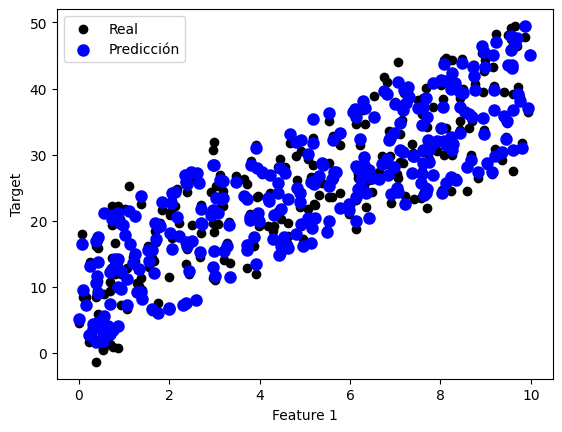

In [55]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data[['feature1', 'feature2']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Imprimir los coeficientes y la intersección
print('Coeficientes:', model.coef_)
print('Intersección:', model.intercept_)

# Visualizar resultados
plt.scatter(X_test['feature1'], y_test, color='black', label='Real')
plt.scatter(X_test['feature1'], y_pred, color='blue', linewidth=3, label='Predicción')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.legend()
plt.show()
